In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from keras.layers import Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('working_dataset.pkl')
df

1,Date,Weekly U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon),Weekly U.S. Imports of Crude Oil and Petroleum Products (Thousand Barrels per Day),Weekly U.S. Imports of Crude Oil (Thousand Barrels per Day),Weekly U.S. Commercial Crude Oil Imports Excluding SPR (Thousand Barrels per Day),Weekly U.S. Crude Oil Imports by SPR (Thousand Barrels per Day),Weekly U.S. Imports of Total Petroleum Products (Thousand Barrels per Day),Weekly U.S. Imports of Total Gasoline (Thousand Barrels per Day),Weekly U.S. Imports of Gasoline Blending Components (Thousand Barrels per Day),Weekly U.S. Imports of Kerosene-Type Jet Fuel (Thousand Barrels per Day),Weekly U.S. Imports of Distillate Fuel Oil (Thousand Barrels per Day),Weekly U.S. Imports of Residual Fuel Oil (Thousand Barrels per Day),Weekly U.S. Exports of Crude Oil and Petroleum Products (Thousand Barrels per Day),Weekly U.S. Exports of Crude Oil (Thousand Barrels per Day),Weekly U.S. Net Imports of Crude Oil and Petroleum Products (Thousand Barrels per Day)
0,733708800,1.068,7501,5512,5512,0,1989,273,26,121,265,456,986,108,6515
1,734313600,1.079,8956,7369,7243,126,1587,328,74,53,260,223,986,108,7970
2,734918400,1.079,7976,6406,6406,0,1570,343,19,100,280,235,986,108,6990
3,735523200,1.086,8715,6804,6662,142,1911,396,43,71,175,320,986,108,7729
4,736128000,1.086,9418,7731,7518,213,1687,209,56,90,120,516,981,111,8437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,1663286400,3.771,8982,6947,6947,0,2035,775,694,50,107,176,10196,3540,-1214
1538,1663891200,3.832,8290,6449,6449,0,1841,525,295,140,94,135,10984,4646,-2694
1539,1664496000,3.909,7319,5947,5947,0,1372,480,431,6,81,156,10612,4551,-3293
1540,1665100800,4.034,7926,6063,6063,0,1862,699,646,76,79,178,9928,2872,-2002


In [3]:
data = df.values
train_X = MinMaxScaler().fit_transform(data[:, 2:])
train_X = np.array([train_X[i-16:i, :] for i in range(16, len(data))], dtype=np.float32)
train_X = tf.convert_to_tensor(train_X)
train_y = tf.convert_to_tensor(data[16:, 1].astype(np.float32))

In [10]:
def build_model(shape, optimizer):
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    random.seed(12345)
    np.random.seed(12345)
    tf.random.set_seed(12345)
    
    model = tf.keras.Sequential()
    model.add(LSTM(units=32, return_sequences=True,
                    input_shape=shape, dropout=0.2))
    model.add(LSTM(units=32, return_sequences=True,
                    dropout=0.2))
    model.add(LSTM(units=32, dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def model_results(train_X, train_y, test_X):
    model = build_model(train_X.shape[1:], 'adam')
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10) 
    history = model.fit(train_X, train_y, epochs=200, batch_size=32, verbose=0, callbacks=[es])
    return history.history['loss'][-1], model.predict(test_X)

In [11]:
history, preds = model_results(train_X, train_y, train_X)

Epoch 87: early stopping


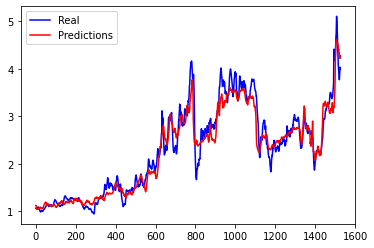

In [12]:
plt.plot(range(len(data)-16), train_y, color='blue', label='Real')
plt.plot(range(len(data)-16), preds, color='red', label='Predictions')
plt.legend()
plt.show()